<a href="https://colab.research.google.com/github/hyeonwooCH/Final_physiognomy_palmistry/blob/main/segface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. 저장소 클론
!git clone https://github.com/Kartik-3004/SegFace.git
%cd SegFace

# 2. 필수 라이브러리 설치
# environment.yml 기반으로 설치해야 하지만, 코랩 기본 환경을 고려해 필수 패키지만 설치합니다.
!pip install timm segmentation-models-pytorch albumentations python-dotenv

Cloning into 'SegFace'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 147 (delta 53), reused 83 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 7.26 MiB | 32.19 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/SegFace
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
import os

# 현재 경로 확인
root_path = os.getcwd()

# .env 파일 생성
with open(".env", "w") as f:
    f.write(f"ROOT_PATH={root_path}\n")
    f.write(f"DATA_PATH={root_path}/data\n")
    f.write(f"LOG_PATH={root_path}/logs\n")

print(".env 파일 생성 완료")

.env 파일 생성 완료


In [ ]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="kartiknarayan/SegFace", filename="convnext_celeba_512/model_299.pt", local_dir="./weights")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


convnext_celeba_512/model_299.pt:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

'weights/convnext_celeba_512/model_299.pt'

In [ ]:
import os
from dotenv import load_dotenv

# .env 파일 생성 재확인
with open(".env", "w") as f:
    f.write(f"ROOT_PATH=/content/SegFace\n")
    f.write(f"DATA_PATH=/content/SegFace/data\n")
    f.write(f"LOG_PATH=/content/SegFace/logs\n")

load_dotenv()
print(f"ROOT_PATH: {os.getenv('ROOT_PATH')}")

ROOT_PATH: /content/SegFace


/content/SegFace
state_dict_backbone 키를 발견했습니다.
모델 로드 완료!


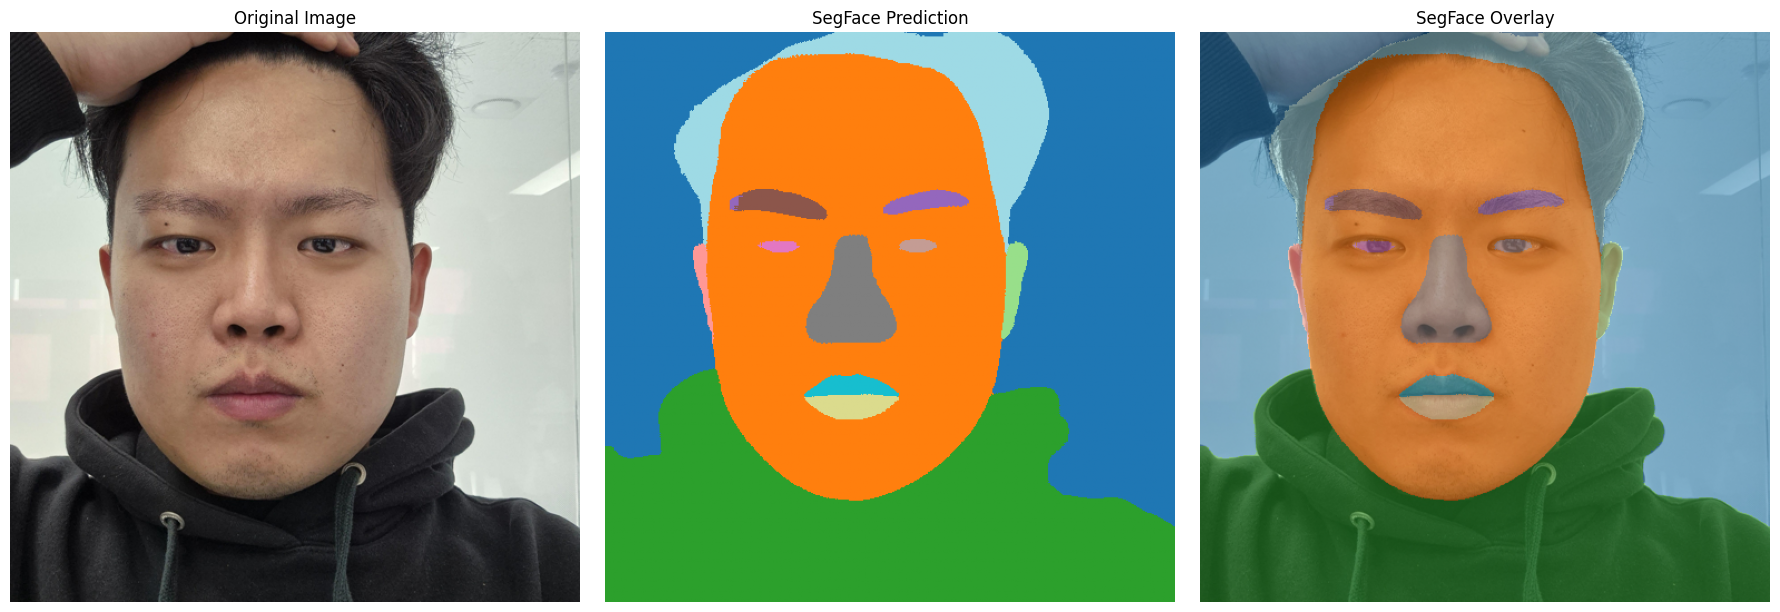

모든 결과가 통합되어 /content/SegFace_combined_result.png 에 저장되었습니다.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os

# 1. 경로 설정 및 모듈 임포트
%cd /content/SegFace
if '/content/SegFace' not in sys.path:
    sys.path.append('/content/SegFace')

# 수정된 경로로 클래스 임포트
from network.models.segface_celeb import SegFaceCeleb

# 2. 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/SegFace/weights/convnext_celeba_512/model_299.pt"
image_path = "/content/mememe_fixed.jpg" # input 바꾸기
input_res = 512

# 3. 모델 초기화 및 가중치 로드
model = SegFaceCeleb(input_res, "convnext_base")

checkpoint = torch.load(model_path, map_location=device)

# 가중치 키 추출 (에러 메시지에 기반하여 state_dict_backbone 등을 확인)
if 'state_dict_backbone' in checkpoint:
    print("state_dict_backbone 키를 발견했습니다.")
    # 저장소의 특이한 구조에 맞춰 가중치를 결합해야 할 수도 있습니다.
    # 일단 가장 확률이 높은 모델 가중치 키를 시도합니다.
    pretrained_dict = checkpoint['state_dict_backbone']
else:
    # 일반적인 경우
    pretrained_dict = checkpoint.get('model_state_dict', checkpoint)

# 현재 모델의 state_dict 가져오기
model_dict = model.state_dict()

# 가중치 이름이 'backbone.'으로 시작하지 않는 경우를 대비해 필터링 (필요 시)
# 아래는 키 이름이 매칭되지 않을 때 강제로 로드하기 위한 설정입니다.
model.load_state_dict(pretrained_dict, strict=False)

model.to(device)
model.eval()
print("모델 로드 완료!")

# 4. 이미지 전처리
img_raw = Image.open(image_path).convert('RGB')
img_resized = img_raw.resize((input_res, input_res))
input_tensor = torch.from_numpy(np.array(img_resized)).permute(2, 0, 1).float().div(255).unsqueeze(0).to(device)

# 5. 추론 (Forward)
with torch.no_grad():
    # 소스 코드의 forward(self, x, labels, dataset) 구조에 대응
    # labels는 딕셔너리 형태, dataset은 텐서 형태의 더미 데이터를 넣어줍니다.
    dummy_labels = {}
    dummy_dataset = torch.tensor([0]).to(device)

    output = model(input_tensor, dummy_labels, dummy_dataset)

    # SegFaceCeleb은 최종적으로 seg_output (텐서)을 반환합니다.
    if isinstance(output, (list, tuple)):
        output = output[0]

    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# 6. 결과 시각화
# 6. 통합 시각화 (원본 | 결과 | 오버레이)
plt.figure(figsize=(18, 6)) # 가로로 길게 배치

# (1) 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_resized)
plt.axis('off')

# (2) 세그멘테이션 결과 (Mask)
plt.subplot(1, 3, 2)
plt.title("SegFace Prediction")
plt.imshow(pred, cmap='tab20')
plt.axis('off')

# (3) 오버레이 결과 (Original + Mask)
plt.subplot(1, 3, 3)
plt.title("SegFace Overlay")
plt.imshow(img_resized) # 먼저 배경에 원본을 깔고
plt.imshow(pred, cmap='tab20', alpha=0.5) # 그 위에 투명도(alpha)를 줘서 출력
plt.axis('off')

# 레이아웃 정렬 및 저장
plt.tight_layout()
plt.savefig("/content/SegFace_combined_result.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

print("모든 결과가 통합되어 /content/SegFace_combined_result.png 에 저장되었습니다.")

In [ ]:
# 코랩 셀에 이 코드 붙이기
import os
import cv2
from PIL import Image, ImageOps
import subprocess

# 원본 이미지 경로
input_image_path = "/content/mememe.jpg"

# EXIF 회전 처리된 이미지 저장할 임시 경로
fixed_image_path = "/content/mememe_fixed.jpg"

# 1단계: EXIF 처리
img = Image.open(input_image_path)
img = ImageOps.exif_transpose(img)  # ★ 회전 적용
img.save(fixed_image_path)

print("✅ EXIF 처리 + 추론 완료!")


✅ EXIF 처리 + 추론 완료!


In [ ]:
# MiDaS 모델을 이용한 간단한 깊이(Depth) 추출 예시
import torch
import cv2
import matplotlib.pyplot as plt

# 1. 모델 로드 (가장 가벼운 버전)
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to('cuda').eval()

# 2. 이미지 변환 설정
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform if model_type == "MiDaS_small" else midas_transforms.dpt_transform

# 3. 깊이 추론
img = cv2.imread('/content/me4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img).to('cuda')

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

# 4. 결과 출력
plt.imshow(depth_map, cmap='magma')
plt.title("3D Depth Map")
plt.show()